## Team 10

## Acute Infarcts location prediction using CNN

# TOPICS
    - data augmentation
    - load dataset
    - dataset preprocessing
    - build the model
    - loss=categorical_crossentropy 
    - softmax activation function
    - optimizer = adam  (extension of stocastic gradient descent)
    
   

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import time
from keras.preprocessing.image import ImageDataGenerator
from os import listdir
%matplotlib inline

Using TensorFlow backend.


In [ ]:
def crop_brain_contour(image,plot=False):
    
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[100:850, 100:750]            

    if plot:
        plt.figure()
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.xticks([])
        plt.yticks([])
            
        plt.subplot(1, 3, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    return new_image

# DATA AUGMENTATION

In [ ]:
def augment_dataset(dir_list):
    """
    Arguments:
        file_dir: A string representing the directory where files containg images that we want to augment are found.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=7, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1,
                                  brightness_range=(0.001, 0.9),
                                  horizontal_flip=False, 
                                  vertical_flip=False, 
                                  fill_mode='nearest'
                                 )
    try:
        os.mkdir('AUGMENTED_DATA')
        for directory in listdir(dir_list):
            save_to_dir="AUGMENTED_DATA/"+ directory
            try:
                os.mkdir(save_to_dir)
            except:
                print(save_to_dir+"is already created")
            filename="DWI.jpg"
            # load the image
            image = cv2.imread(dir_list + '\\'+directory + '\\' + "DWI.jpg")
            
            #imageref = cv2.imread("CLEANED_DATA_1" + '\\'+directory + '\\' + "FLAIR.jpg")
            # crop the brain and ignore the unnecessary rest part of the image
            #image = crop_brain_contour(image, plot=False)

            image = image.reshape((1,) + image.shape)
            # prefix of the names for the generated sampels.
            save_prefix = 'aug_' + filename[:-4]
            
            i=0
            for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix,
                                       save_format='jpg'):
                i += 1
                if i > 20:
                    break
    except:
        print("AUGMENTED_DATA is already created")
        
    
    return 0

In [ ]:
augment_dataset("CLEANED_DATA")

AUGMENTED_DATA is already created


0

# LOAD THE DATA

In [ ]:
grouped={ 
  'Bilateral cerebellar hemispheres':0,
  'Bilateral cerebellar hemispheres and vermis':0,
  'Bilateral frontal lobes':1,
  'Bilateral occipital lobes':2,
  'Brainstem':3,
  'Lacunar infarct in dorsal aspect of pons':3,
  'Lacunar infarct in left parietal lobe':4,
  'Lacunar infarct in medulla oblongata on the left':5,
  'Lacunar infarct in pons on the left':6,
  'Lacunar infarct in posterior limb of left internal capsule':7,
  'Lacunar infarct in right corona radiata':8,
  'Lacunar infarct in right putamen':9,
  'Lacunar infarcts in bilateral occipital lobes':2,
  'Lacunar infarcts in left corona radiata':10,
  'Lacunar infarcts in the right parietal lobe':11,
  'Left centrum semi ovale and right parietal lobe':12,
  'Left cerebellar hemisphere':13,
  'Left cerebellar lacunar infarcts':13,
  'Left frontal lobe':14,
  'Left frontal lobe in precentral gyral location':15,
  'Left fronto-parietal lobe':14,
  'Left fronto-temporo-parietal region':16,
  'Left insula':14,
  'Left occipital and temporal lobes':17,
  'Left occipital lobe':18,
  'Left parietal lobe':4,
  'Left thalamic lacunar infarct':19,
  'Medial part of right frontal and parietal lobes':20,
  'Mid brain on right side':21,
  'Pontine infarct on the right':22,
  'Right anterior thalamic infarct':23,
  'Right cerebellar hemisphere':24,
  'Right cerebellar hemisphere infarct':24,
  'Right corona radiata':8,
  'Right frontal lobe':25,
  'Right fronto-parietal lobe':26,
  'Right fronto-parieto-temporo- occipital lobes':27,
  'Right ganglio-capsular region':26,
  'Right insula':28,
  'Right lentiform nucleus':29,
  'Right occipital lobe':30,
  'Right parietal lacunar infarct':11,
  'Right parietal lobe':11,
  'Right temporal lobe':31,
  'Right thalamus':32,
  'Splenium of the corpus callosum':33}

In [ ]:
combined = {
0: '0: Bilateral cerebellar hemispheres or 1: Bilateral cerebellar hemispheres and vermis',
1: '2: Bilateral frontal lobes',
2: '3: Bilateral occipital lobes or  12: Lacunar infarcts in bilateral occipital lobes',
3: '4: Brainstem or 5: Lacunar infarct in dorsal aspect of pons',
4: '6: Lacunar infarct in left parietal lobe or 25 :Left parietal lobe',
5: '7: Lacunar infarct in medulla oblongata on the left',
6: '8: Lacunar infarct in pons on the left',
7: '9: Lacunar infarct in posterior limb of left internal capsule',
8: '10: Lacunar infarct in right corona radiata or 33: Right corona radiata',
9: '11: Lacunar infarct in right putamen',
10:'13: Lacunar infarcts in left corona radiata',
11:'14: Lacunar infarcts in the right parietal lobe or 41: Right parietal lacunar infarct or 42: Right parietal lobe',
12:'15: Left centrum semi ovale and right parietal lobe ',
13:'16: Left cerebellar hemisphere or 17: Left cerebellar lacunar infarcts',
14:'18: Left frontal lobe or 20: Left fronto-parietal lobe or 22: Left insula',
15:'19: Left frontal lobe in precentral gyral location',
16:'21: Left fronto-temporo-parietal region',
17:'23: Left occipital and temporal lobes',
18:'24: Left occipital lobe',
19:'26: Left thalamic lacunar infarct',
20:'27: Medial part of right frontal and parietal lobes',
21:'28: Mid brain on right side',
22:'29: Pontine infarct on the right',
23:'30: Right anterior thalamic infarct',
24:'31: Right cerebellar hemisphere or 32: Right cerebellar hemisphere infarct',
25:'34: Right frontal lobe',
26:'35: Right fronto-parietal lobe or 37: Right ganglio-capsular region',
27:'36: Right fronto-parieto-temporo- occipital lobes',
28:'38: Right insula',
29:'39: Right lentiform nucleus',
30:'40: Right occipital lobe',
31:'43: Right temporal lobe',
32:'44: Right thalamus',
33:'45: Splenium of the corpus callosum'}

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    target_names={}
    i=0
    for directory in os.listdir(dir_list):
        target_names[grouped[directory]] = combined[grouped[directory]]
        for filename in os.listdir(dir_list+'\\'+directory):
            # load the image
            image = cv2.imread(dir_list + '\\'+directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = image[100:850, 100:750]
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            y.append(grouped[directory])
        i=i+1
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    return X, y,target_names

In [ ]:
X,y,target_names = load_data("AUGMENTED_DATA",[32,32])
 

Number of examples is: 966
X shape is: (966, 32, 32, 3)
y shape is: (966,)


In [ ]:
#groupes Classes
target_names

{0: '0: Bilateral cerebellar hemispheres or 1: Bilateral cerebellar hemispheres and vermis',
 1: '2: Bilateral frontal lobes',
 2: '3: Bilateral occipital lobes or  12: Lacunar infarcts in bilateral occipital lobes',
 3: '4: Brainstem or 5: Lacunar infarct in dorsal aspect of pons',
 4: '6: Lacunar infarct in left parietal lobe or 25 :Left parietal lobe',
 5: '7: Lacunar infarct in medulla oblongata on the left',
 6: '8: Lacunar infarct in pons on the left',
 7: '9: Lacunar infarct in posterior limb of left internal capsule',
 8: '10: Lacunar infarct in right corona radiata or 33: Right corona radiata',
 9: '11: Lacunar infarct in right putamen',
 10: '13: Lacunar infarcts in left corona radiata',
 11: '14: Lacunar infarcts in the right parietal lobe or 41: Right parietal lacunar infarct or 42: Right parietal lobe',
 12: '15: Left centrum semi ovale and right parietal lobe ',
 13: '16: Left cerebellar hemisphere or 17: Left cerebellar lacunar infarcts',
 14: '18: Left frontal lobe or 2

# PLOT SAMPLES

In [ ]:
def plot_sample_images(X, y,target_names,n=10):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        target_names: Dictonary with key value is no assigned to respective brain region.
    """
    
    for label in target_names.keys():
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 1))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            plt.xticks([])
            plt.yticks([])
            i += 1
        
        label_to_str = lambda label: target_names[label]
        plt.suptitle(f"Brain inffract: {label_to_str(label)}")
        plt.show()

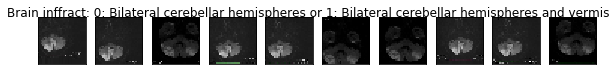

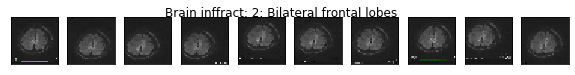

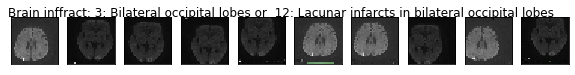

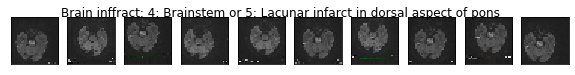

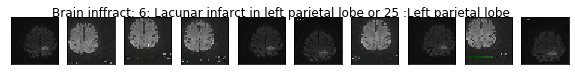

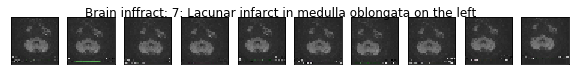

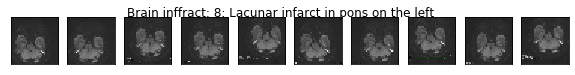

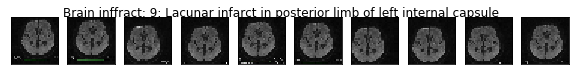

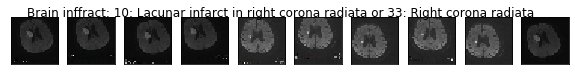

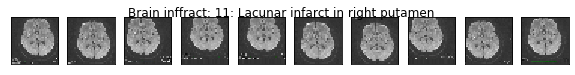

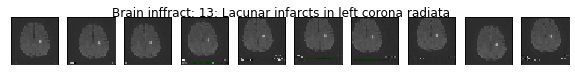

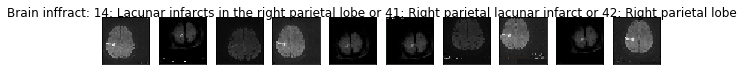

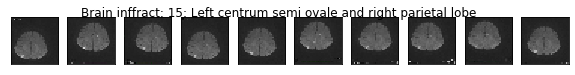

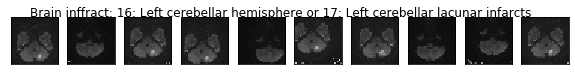

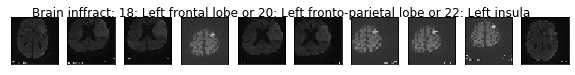

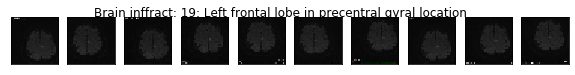

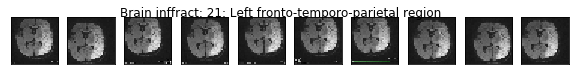

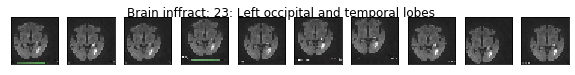

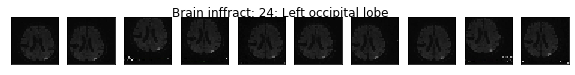

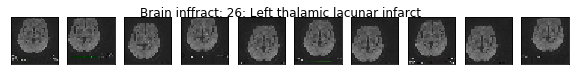

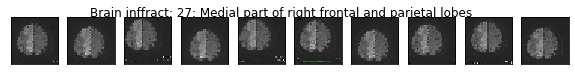

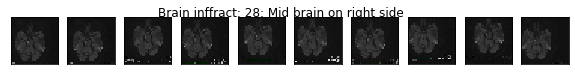

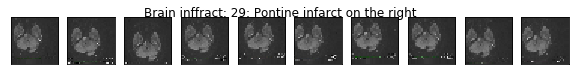

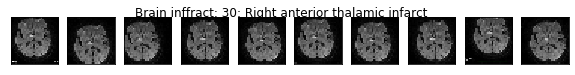

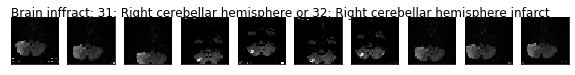

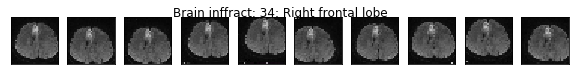

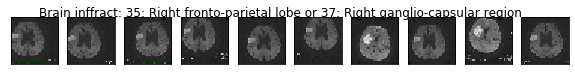

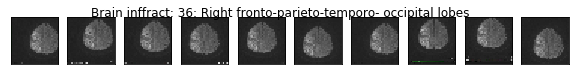

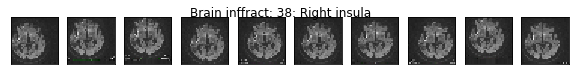

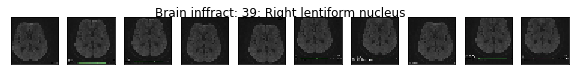

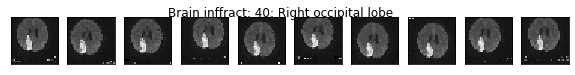

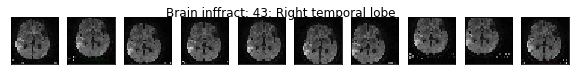

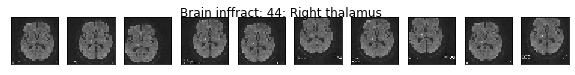

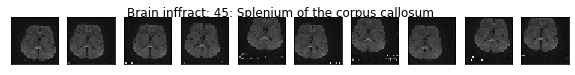

In [ ]:
plot_sample_images(X, y,target_names)

# LOAD TEST IMAGES

In [ ]:
#Using Inference for testing
y_infer = [11,6,13,7,18,17,31,"nil",8,12,19,"nil",16,10,11,14,"nil",11,11,24,13,"nil","nil",25,"nil",14,"nil",26,"nil",8,29,32,11,24,32,12,4,8,25,31]
#print(len(y_infer))
#Loading X_test_1 and y_test_1
def read_image(location, image_size):
    image_width, image_height = image_size
    image = cv2.imread(location + '\\' + 'DWI.jpg')
    image = crop_brain_contour(image,True)
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    image = image / 255.
    return image

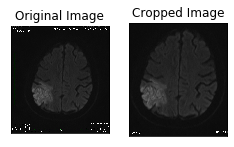

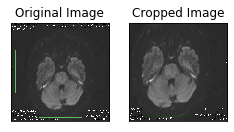

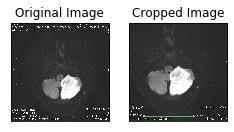

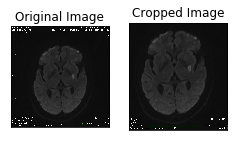

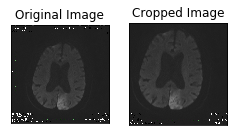

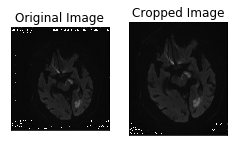

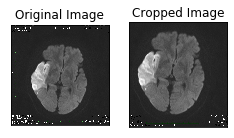

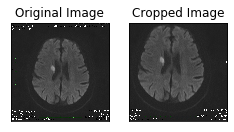

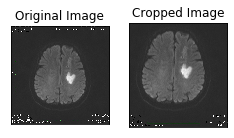

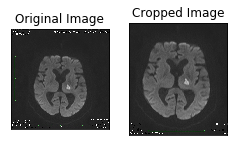

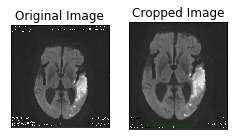

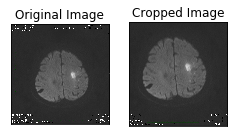

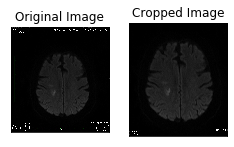

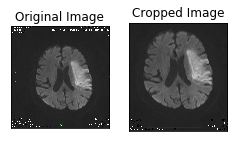

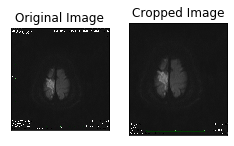

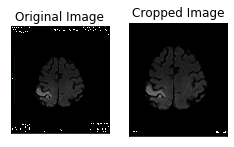

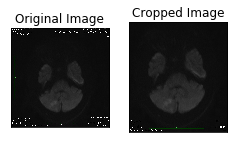

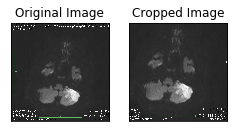

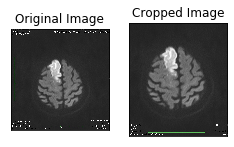

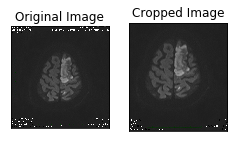

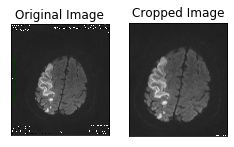

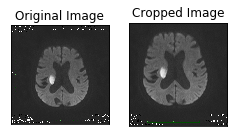

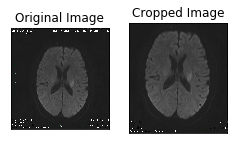

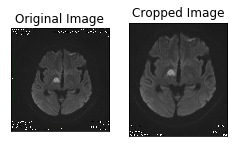

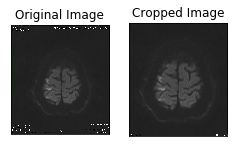

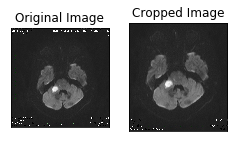

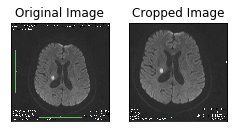

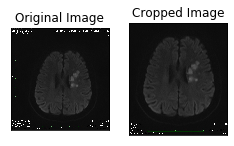

In [ ]:
X_test =[]
y_test = []
for i in range(1,37):
    if(y_infer[i-1] != "nil"):
        img = read_image("Inference_Data\Case "+str(i),[32,32])
        X_test.append(img)
        y_test.append(y_infer[i-1])

X_test= np.array(X_test)
y_test = np.array(y_test)

# SPLIT THE DATASET

In [ ]:
#from sklearn.model_selection import train_test_split
print("X_train =",X.shape)
print("X_test =",X_test.shape)
print("y_train =",y.shape)
print("y_test =",y_test.shape)

X_train = (966, 32, 32, 3)
X_test = (28, 32, 32, 3)
y_train = (966,)
y_test = (28,)


# BUILDING MODEL 

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (32, 32)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
NUM_CLASSES = 34

In [ ]:
def build_model(input_shape,num_classes=34):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
        num_classes: number of output neurons
    Returns:
        model: A Model object.
    """ 
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [ ]:
model = build_model(IMG_SHAPE,NUM_CLASSES)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 29, 29, 32)        1568      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 150)               235350    
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 34)                5134      
Total params: 242,052
Trainable params: 242,052
Non-trainable params: 0
________________________________________________

### COMPILE THE MODEL

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y)
y_test1= lb.transform(y_test)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CHECKPOINT

In [ ]:
#callbacks
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)


### TRAINING THE MODEL

In [ ]:
model.fit(x=X, y=y_train, batch_size=21, epochs=40,validation_split=0.2,callbacks=[es])

Train on 772 samples, validate on 194 samples
Epoch 1/40
772/772 [==============================] - 2s 3ms/sample - loss: 3.4997 - acc: 0.0622 - val_loss: 3.4366 - val_acc: 0.1031
Epoch 2/40
772/772 [==============================] - 1s 2ms/sample - loss: 3.3067 - acc: 0.1036 - val_loss: 3.2015 - val_acc: 0.1186
Epoch 3/40
772/772 [==============================] - 1s 2ms/sample - loss: 3.0734 - acc: 0.1373 - val_loss: 2.9907 - val_acc: 0.1546
Epoch 4/40
772/772 [==============================] - 2s 3ms/sample - loss: 2.8482 - acc: 0.2085 - val_loss: 2.7030 - val_acc: 0.2577
Epoch 5/40
772/772 [==============================] - 2s 2ms/sample - loss: 2.5866 - acc: 0.2733 - val_loss: 2.4038 - val_acc: 0.3402
Epoch 6/40
772/772 [==============================] - 1s 2ms/sample - loss: 2.3330 - acc: 0.3290 - val_loss: 2.1368 - val_acc: 0.4639
Epoch 7/40
772/772 [==============================] - 2s 2ms/sample - loss: 2.1166 - acc: 0.3834 - val_loss: 1.9209 - val_acc: 0.4330
Epoch 8/40
772/7

## PLOT OF ACCURACY AND LOSS

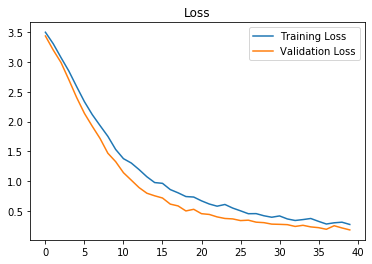

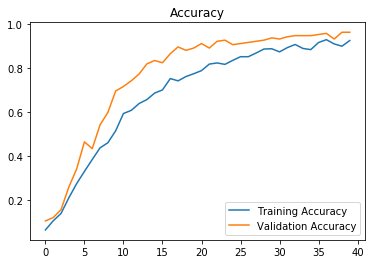

In [ ]:
history = model.history.history
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history) 

## TESTING 

In [ ]:
loss, acc = model.evaluate(x=X_test, y=y_test1)

28/28 [==============================] - 0s 374us/sample - loss: 4.7916 - acc: 0.4286


In [ ]:
r=model.predict(X_test)
y_predicted=[]
predicted_names={ }
correct1=[]
correct2=[]
correct3=[]
for i in range(0,len(r)):
    print("target=",target_names[y_test[i]])
    l=r[i]
    if(target_names[y_test[i]] in target_names[l.argmax()]):
        correct1.append(y_test[i])
    print("predicted 1 = ",target_names[l.argmax()],l.max())
    y_predicted.append(l.argmax())
    l[l.argmax()]=0
    if(target_names[y_test[i]] in target_names[l.argmax()]):
       correct2.append(y_test[i])
    print("predicted 2 = ",target_names[l.argmax()],l.max())
    l[l.argmax()]=0
    if(target_names[y_test[i]] in target_names[l.argmax()]):
      correct3.append(y_test[i])
    print("predicted 3 = ",target_names[l.argmax()],l.max())
    
print(correct1)
print(correct2)
print(correct3)
print(len(correct1), len(correct2), len(correct3))
print("out of")
print(len(y_test))

target= 14: Lacunar infarcts in the right parietal lobe or 41: Right parietal lacunar infarct or 42: Right parietal lobe
predicted 1 =  14: Lacunar infarcts in the right parietal lobe or 41: Right parietal lacunar infarct or 42: Right parietal lobe 0.43376538
predicted 2 =  19: Left frontal lobe in precentral gyral location 0.16606744
predicted 3 =  28: Mid brain on right side 0.13105698
target= 8: Lacunar infarct in pons on the left
predicted 1 =  7: Lacunar infarct in medulla oblongata on the left 0.8212243
predicted 2 =  29: Pontine infarct on the right 0.12698045
predicted 3 =  8: Lacunar infarct in pons on the left 0.03554783
target= 16: Left cerebellar hemisphere or 17: Left cerebellar lacunar infarcts
predicted 1 =  0: Bilateral cerebellar hemispheres or 1: Bilateral cerebellar hemispheres and vermis 0.7119933
predicted 2 =  2: Bilateral frontal lobes 0.2785678
predicted 3 =  40: Right occipital lobe 0.008412352
target= 9: Lacunar infarct in posterior limb of left internal capsu

# Converting to .pb


    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.

In [ ]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
   
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])

INFO:tensorflow:Froze 167 variables.
INFO:tensorflow:Converted 167 variables to const ops.


In [ ]:
tf.train.write_graph(frozen_graph, os.getcwd(), 'acute_infarcts_1.pb', as_text=False)

'C:\\Users\\venum\\Envs\\PES_AI_PIP\\acute_infarcts_1.pb'

## Loading .pb file

In [ ]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    f = gfile.FastGFile(str(os.getcwd())+'\\'+'pro.pb', 'rb')
    graph_def = tf.GraphDef()
    # Parses a serialized binary message into the current message.
    graph_def.ParseFromString(f.read())
    f.close()

    sess.graph.as_default()
    # Import a serialized TensorFlow `GraphDef` protocol buffer
    # and place into the current default `Graph`.
    g_in = tf.import_graph_def(graph_def)

In [ ]:
writer = tf.summary.FileWriter(str(os.getcwd())+'\log')
writer.add_graph(sess.graph)
writer.flush()
writer.close()

In [ ]:
# Infered data

In [ ]:
####Inference Engine
from openvino.inference_engine import IENetwork, IEPlugin
import os
import time
import cv2
import argparse
import numpy as np
import tkinter as tk

root= tk.Tk()
canvas1 = tk.Canvas(root, width = 300, height = 300)
canvas1.pack()

target_names = {0: '0: Bilateral cerebellar hemispheres or 1: Bilateral cerebellar hemispheres and vermis',
1: '2: Bilateral frontal lobes',
2: '3: Bilateral occipital lobes or  12: Lacunar infarcts in bilateral occipital lobes',
3: '4: Brainstem or 5: Lacunar infarct in dorsal aspect of pons',
4: '6: Lacunar infarct in left parietal lobe or 25 :Left parietal lobe',
5: '7: Lacunar infarct in medulla oblongata on the left',
6: '8: Lacunar infarct in pons on the left',
7: '9: Lacunar infarct in posterior limb of left internal capsule',
8: '10: Lacunar infarct in right corona radiata or 33: Right corona radiata',
9: '11: Lacunar infarct in right putamen',
10:'13: Lacunar infarcts in left corona radiata',
11:'14: Lacunar infarcts in the right parietal lobe or 41: Right parietal lacunar infarct or 42: Right parietal lobe',
12:'15: Left centrum semi ovale and right parietal lobe ',
13:'16: Left cerebellar hemisphere or 17: Left cerebellar lacunar infarcts',
14:'18: Left frontal lobe or 20: Left fronto-parietal lobe or 22: Left insula',
15:'19: Left frontal lobe in precentral gyral location',
16:'21: Left fronto-temporo-parietal region',
17:'23: Left occipital and temporal lobes',
18:'24: Left occipital lobe',
19:'26: Left thalamic lacunar infarct',
20:'27: Medial part of right frontal and parietal lobes',
21:'28: Mid brain on right side',
22:'29: Pontine infarct on the right',
23:'30: Right anterior thalamic infarct',
24:'31: Right cerebellar hemisphere or 32: Right cerebellar hemisphere infarct',
25:'34: Right frontal lobe',
26:'35: Right fronto-parietal lobe or 37: Right ganglio-capsular region',
27:'36: Right fronto-parieto-temporo- occipital lobes',
28:'38: Right insula',
29:'39: Right lentiform nucleus',
30:'40: Right occipital lobe',
31:'43: Right temporal lobe',
32:'44: Right thalamus',
33:'45: Splenium of the corpus callosum'}
#reading the model----
model_xml ="mir_tumor_predict"

model_xml = str(os.path.splitext(model_xml)[0])+ ".xml"
model_bin = str(os.path.splitext(model_xml)[0])+ ".bin"

#Setup Devices----
plugin = IEPlugin(device=str('CPU')) #MYRIAD
net = IENetwork(model=model_xml, weights=model_bin)

#Allocating input and output blobs----
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))


#load model to plugin----
exec_net = plugin.load(network=net, num_requests=2)

#read and preprocess input images---
n, c, h, w = net.inputs[input_blob].shape
#print(n,c,h,w)


for i in range(len(X_test)):
            #filename="DWI.jpg"
            # load the image
            #image = cv2.imread("inference_data" + '\\'+directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = X_test[i]
            if(image[:-1] != (w,h)):
                image = cv2.resize(image, (w, h))
            image=image/255
            image = image.transpose((2,0,1)) #as openvino expects in this format HWC to CHW
            res = exec_net.infer(inputs={input_blob:image})
            res = res[out_blob]
            #print(res)
            l=res
            print(y_test[i]])
            print("target :",target_names[y_test[i]])
            print("predicted 1 = %s with %s",target_names[l.argmax()],l.max())
            l[0][l.argmax()]=0
            print("predicted 2 = %s with %s",target_names[l.argmax()],l.max())
            l[0][l.argmax()]=0
            print("predicted 3 = %s with %s",target_names[l.argmax()],l.max())

root.mainloop()
